## Synthetic Financial Datasets for Fraud Detection

### 데이터 설명
1,지급,1060.31,C429214117,1089.0,28.69,M1591654462,0.0,0.0,0.0,0,0,0,0,0

단계 - 실제 시간 단위를 매핑합니다. 이 경우 1단계는 1시간입니다. 총 744단계(30일 시뮬레이션)

유형 - 현금 입력, 현금 인출, 직불, 지불 및 이체.

양 -
현지 통화의 거래 금액

name 오리진 - 트랜잭션을 시작한 고객

oldbalance Org - 거래 전 초기 잔액

새 잔액 원산지 - 거래 후 새 잔액

nameDest - 트랜잭션의 수신인인 고객

oldbalanceDest - 트랜잭션 전의 초기 잔액 수신자입니다. M(상인)으로 시작하는 고객을 위한 정보는 없습니다.

new balanceDest - 트랜잭션 후 새 밸런스 수신인. M(상인)으로 시작하는 고객을 위한 정보는 없습니다.

isFraud - 시뮬레이션 내의 사기성 에이전트에 의한 트랜잭션입니다. 이 특정 데이터 세트에서 에이전트의 사기 행위는 통제나 고객 계정을 가져와서 이익을 얻으려고 하고 다른 계정으로 옮긴 다음 시스템에서 현금화함으로써 자금을 비우려고 한다.

Flagged Fraud - 이 비즈니스 모델은 한 계정에서 다른 계정으로 대량의 전송을 제어하고 불법적인 시도를 하는 것을 목표로 합니다. 이 데이터 집합에서 잘못된 시도는 단일 트랜잭션에서 200.000개 이상을 전송하려는 시도입니다.

과거 연구
5개의 다른 시나리오의 실행을 포함하는 유사한 파일이 5개 있습니다. 이러한 파일은 제 박사 논문 7장(PhD 논문 사용 가능여기 http://urn.kb.se/resolve?urn=urn:nbn:se:bth-12932)에서 더 잘 설명합니다.

### 1. Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import average_precision_score
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance, to_graphviz

In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
df = pd.read_csv("./data/PS_20174392719_1491204439457_log.csv")

In [4]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [5]:
df = df.rename(columns={"oldbalanceOrg" : "oldBalanceOrig", "newbalanceOrig":"newBalanceOrig", "oldbalanceDest":"oldBalanceDest", "newbalanceDest":"newBalanceDest"})
print(df.head())

   step      type    amount     nameOrig  oldBalanceOrig  newBalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815        170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295         21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145           181.0            0.00   
3     1  CASH_OUT    181.00   C840083671           181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720         41554.0        29885.86   

      nameDest  oldBalanceDest  newBalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  


In [6]:
df.isnull().values.any()

False

### 2. Exploratory Data Analysis

#### 어느 유형이 주로 사기 가능성이 있는지
- 5가지 유형 중 송금(Transfer)와 고객/사기꾼에게 현금으로 돈을 지불하는 상인에게 보내는 현금화(Cash_out)에서 나오는데 부정 이전 횟수는 사기성 CASH_OUT 횟수와 거의 일치함

In [7]:
print("\n The types of fraudulent transactions are {}".format(list(df.loc[df.isFraud == 1].type.drop_duplicates().values)))

dfFraudTransfer = df.loc[(df.isFraud == 1) & (df.type == "TRANSFER")]
dfFraudCashout = df.loc[(df.isFraud == 1) & (df.type == "CASH_OUT")]

print("\n The number of fraudulent TRANSFERs = {}".format(len(dfFraudTransfer)))
print("\n The number of fraudulent CASH_OUTs = {}".format(len(dfFraudCashout)))


 The types of fraudulent transactions are ['TRANSFER', 'CASH_OUT']

 The number of fraudulent TRANSFERs = 4097

 The number of fraudulent CASH_OUTs = 4116


#### 어떤 특징이 사기인지 구별할 수 있는지

In [8]:
print("\n The type of transactions in which isFlaggedFraud is set: {}".format(list(df.loc[df.isFlaggedFraud == 1].type.drop_duplicates())))

dfTransfer = df.loc[df.type == "TRANSFER"]
dfFlagged = df.loc[df.isFlaggedFraud == 1]
dfNotFlagged = df.loc[df.isFlaggedFraud == 0]

print("\n Min amount transacted when isFlaggedFraud is set = {}".format(dfFlagged.amount.min()))
print("\n Max amount transacted in a TRANSFER where isFlaggedFraud is not set = {}".format(dfTransfer.loc[dfTransfer.isFlaggedFraud == 0].amount.max()))


 The type of transactions in which isFlaggedFraud is set: ['TRANSFER']

 Min amount transacted when isFlaggedFraud is set = 353874.22

 Max amount transacted in a TRANSFER where isFlaggedFraud is not set = 92445516.64


In [9]:
print("\n The number of TRANSFERs where isFlaggedFraud = 0, yet oldBalanceDest = 0 and newBalanceDest = 0: {}".format(len(dfTransfer.loc[(dfTransfer.isFlaggedFraud == 0) & (dfTransfer.oldBalanceDest == 0) & (dfTransfer.newBalanceDest == 0)])))


 The number of TRANSFERs where isFlaggedFraud = 0, yet oldBalanceDest = 0 and newBalanceDest = 0: 4158


In [10]:
print('\nMin, Max of oldBalanceOrig for isFlaggedFraud = 1 TRANSFERs: {}'.\
format([round(dfFlagged.oldBalanceOrig.min()), round(dfFlagged.oldBalanceOrig.max())]))

print('\nMin, Max of oldBalanceOrig for isFlaggedFraud = 0 TRANSFERs where \
oldBalanceOrig = \
newBalanceOrig: {}'.format(\
[dfTransfer.loc[(dfTransfer.isFlaggedFraud == 0) & (dfTransfer.oldBalanceOrig \
== dfTransfer.newBalanceOrig)].oldBalanceOrig.min(), \
round(dfTransfer.loc[(dfTransfer.isFlaggedFraud == 0) & (dfTransfer.oldBalanceOrig \
               == dfTransfer.newBalanceOrig)].oldBalanceOrig.max())]))


Min, Max of oldBalanceOrig for isFlaggedFraud = 1 TRANSFERs: [353874, 19585040]

Min, Max of oldBalanceOrig for isFlaggedFraud = 0 TRANSFERs where oldBalanceOrig = newBalanceOrig: [0.0, 575668]


In [11]:
print("\n Have originators of transactions flagged as fraud transacted more than once? {}".format((dfFlagged.nameOrig.isin(pd.concat([dfNotFlagged.nameOrig, dfNotFlagged.nameDest]))).any()))
print('\nHave destinations for transactions flagged as fraud initiated\
 other transactions? \
{}'.format((dfFlagged.nameDest.isin(dfNotFlagged.nameOrig)).any()))
print('\nHow many destination accounts of transactions flagged as fraud have been \
destination accounts more than once?: {}'\
.format(sum(dfFlagged.nameDest.isin(dfNotFlagged.nameDest))))


 Have originators of transactions flagged as fraud transacted more than once? False

Have destinations for transactions flagged as fraud initiated other transactions? False

How many destination accounts of transactions flagged as fraud have been destination accounts more than once?: 2


#### 2.3 예상되는 가맹점에 라벨이 붙여져 있는지?

In [12]:
print('\nAre there any merchants among destination accounts for CASH_OUT \
transactions? {}'.format(\
(df.loc[df.type == 'CASH_OUT'].nameDest.str.contains('M')).any()))


Are there any merchants among destination accounts for CASH_OUT transactions? False


In [13]:
print("Are there merchants among any originator accounts? {}".format(
    df.nameOrig.str.contains("M").any()))
print('\nAre there any transactions having merchants among destination accounts\
 other than the PAYMENT type? {}'.format(\
(df.loc[df.nameDest.str.contains('M')].type != 'PAYMENT').any()))

Are there merchants among any originator accounts? False

Are there any transactions having merchants among destination accounts other than the PAYMENT type? False


#### 2.4 부정한 양도 및 CASH_OUT에 공통적인 계정 라벨이 잇는지?

In [14]:
print("\n Within faudulent transactions, are there destinations for TRANSERS that are also originators for CASH_OUTs? {}".format((dfFraudTransfer.nameDest.isin(dfFraudCashout.nameOrig)).any()))
dfNotFraud = df.loc[df.isFraud == 0]


 Within faudulent transactions, are there destinations for TRANSERS that are also originators for CASH_OUTs? False


In [15]:
print('\nFraudulent TRANSFERs whose destination accounts are originators of \
genuine CASH_OUTs: \n\n{}'.format(dfFraudTransfer.loc[dfFraudTransfer.nameDest.\
isin(dfNotFraud.loc[dfNotFraud.type == 'CASH_OUT'].nameOrig.drop_duplicates())]))


Fraudulent TRANSFERs whose destination accounts are originators of genuine CASH_OUTs: 

         step      type      amount     nameOrig  oldBalanceOrig  \
1030443    65  TRANSFER  1282971.57  C1175896731      1282971.57   
6039814   486  TRANSFER   214793.32  C2140495649       214793.32   
6362556   738  TRANSFER   814689.88  C2029041842       814689.88   

         newBalanceOrig     nameDest  oldBalanceDest  newBalanceDest  isFraud  \
1030443             0.0  C1714931087             0.0             0.0        1   
6039814             0.0   C423543548             0.0             0.0        1   
6362556             0.0  C1023330867             0.0             0.0        1   

         isFlaggedFraud  
1030443               0  
6039814               0  
6362556               0  


In [16]:
print('\nFraudulent TRANSFER to C423543548 occured at step = 486 whereas \
genuine CASH_OUT from this account occured earlier at step = {}'.format(\
dfNotFraud.loc[(dfNotFraud.type == 'CASH_OUT') & (dfNotFraud.nameOrig == \
                           'C423543548')].step.values))


Fraudulent TRANSFER to C423543548 occured at step = 486 whereas genuine CASH_OUT from this account occured earlier at step = [185]


### 3. Data Cleaning

In [17]:
X = df.loc[(df.type == "TRANSFER") | (df.type == "CASH_OUT")]

randomState = 5
np.random.seed(randomState)

Y = X["isFraud"]
del X["isFraud"]

X = X.drop(["nameOrig", "nameDest", "isFlaggedFraud"], axis = 1)
X.loc[X.type == "TRANSFER", "type"] = 0
X.loc[X.type == "CASH_OUT", "type"] = 1
X.type = X.type.astype(int)

In [18]:
Xfraud = X.loc[Y == 1]
XnonFraud = X.loc[Y == 0]
print('\nThe fraction of fraudulent transactions with \'oldBalanceDest\' = \
\'newBalanceDest\' = 0 although the transacted \'amount\' is non-zero is: {}'.\
format(len(Xfraud.loc[(Xfraud.oldBalanceDest == 0) & \
(Xfraud.newBalanceDest == 0) & (Xfraud.amount)]) / (1.0 * len(Xfraud))))

print('\nThe fraction of genuine transactions with \'oldBalanceDest\' = \
newBalanceDest\' = 0 although the transacted \'amount\' is non-zero is: {}'.\
format(len(XnonFraud.loc[(XnonFraud.oldBalanceDest == 0) & \
(XnonFraud.newBalanceDest == 0) & (XnonFraud.amount)]) / (1.0 * len(XnonFraud))))


The fraction of fraudulent transactions with 'oldBalanceDest' = 'newBalanceDest' = 0 although the transacted 'amount' is non-zero is: 0.4955558261293072

The fraction of genuine transactions with 'oldBalanceDest' = newBalanceDest' = 0 although the transacted 'amount' is non-zero is: 0.0006176245277308345


In [19]:
X.loc[(X.oldBalanceDest == 0) & (X.newBalanceDest == 0) & (X.amount != 0), \
      ['oldBalanceDest', 'newBalanceDest']] = - 1

In [20]:
X.loc[(X.oldBalanceOrig == 0) & (X.newBalanceOrig == 0) & (X.amount != 0), \
      ['oldBalanceOrig', 'newBalanceOrig']] = np.nan

### 4. Feature-engineering

In [21]:
X["errorBalanceOrig"] = X.newBalanceOrig + X.amount - X.oldBalanceOrig
X["errorBalanceDest"] = X.oldBalanceDest + X.amount - X.newBalanceDest

### 5. Data visualization

In [22]:
limit = len(X)

def plotStrip(x, y, hue, figsize = (14, 9)):
    fig = plt.figure(figsize = figsize)
    colours = plt.cm.tab10(np.linspace(0, 1, 9))
    with sns.axes_style("ticks"):
        ax = sns.stripplot(x, y, 
                          hue = hue,
                          jitter = 0.4,
                          marker = ".",
                          size = 4,
                          palette = colours)
        ax.set_xlabel("")
        ax.set_xticklabels(["genuine", "fraudulent"], size = 16)
        for axis in ["top", "bottom", "left", "right"]:
            ax.spines[axis].set_linewidth(2)
        
        handles, label = ax.get_legend_handles_labels()
        plt.legend(handles, ["Transfer", "Cash out"], bbox_to_anchor=(1, 1),
                  loc = 2, borderaxespad = 0, fontsize = 16)
        return ax

#### 5.1 Dispersion over time

아래 그림은 시간이 지남에 따라 분산이 확인될 때 부정 거래와 실제 거래가 어떻게 다른 지문을 생성하는지를 보여줍니다. 부정거래는 실제 거래와 비교해 시간이 지날수록 균질하게 유통되는 것이 분명하다. 또한 CASH-OUTs가 부정거래에서 그들 사이의 균형잡힌 분배와 대조적으로, 진짜 거래에서 이전보다 더 많다는 것도 명백하다. 각 '지문'의 너비는 위의 플롯 스트립 함수의 '지터' 매개 변수에 의해 설정되며, 이 매개 변수는 서로 다른 압시새와 동시에 발생하는 트랜잭션을 분리하고 플로팅하려고 시도합니다.

/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Striped vs homogenous fingerprints of genuine and fraudulent transactions over time')

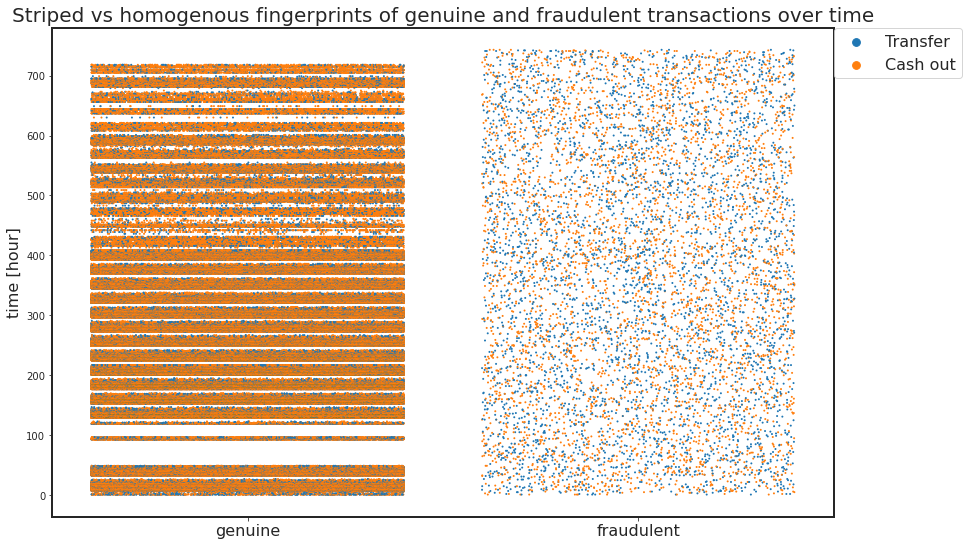

In [23]:
ax = plotStrip(Y[:limit], X.step[:limit], X.type[:limit])
ax.set_ylabel("time [hour]", size = 16)
ax.set_title("Striped vs homogenous fingerprints of genuine and fraudulent transactions over time", size = 20)

#### 5.2 Dispersion over amount

/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Same-signed fingerprints of genuine and fraudulent transactions over amount')

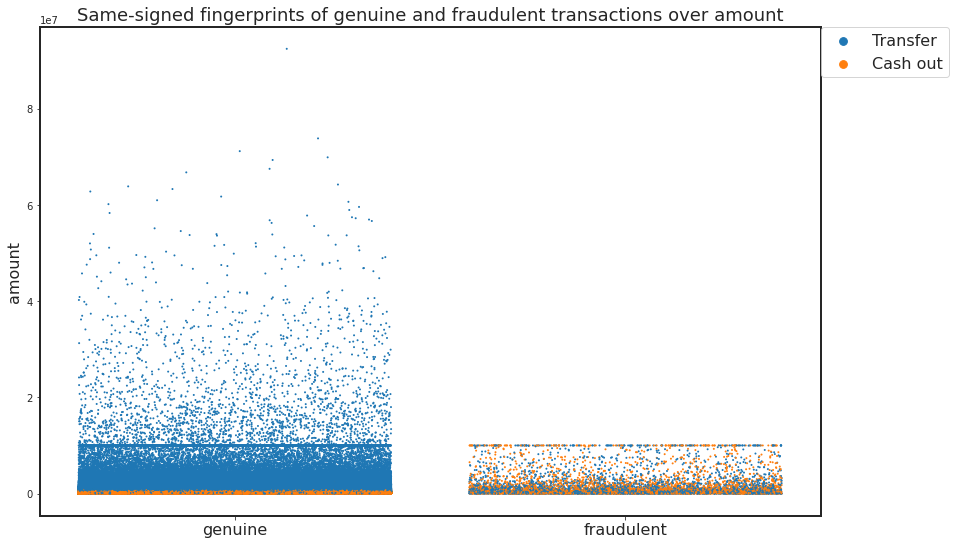

In [24]:
limit = len(X)
ax = plotStrip(Y[:limit], X.amount[:limit], X.type[:limit], figsize = (14, 9))
ax.set_ylabel("amount", size = 16)
ax.set_title("Same-signed fingerprints of genuine and fraudulent transactions over amount", size = 18)

#### 5.3 Dispersion over error in balance in destination accounts

/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Opposite polarity fingerprints over the error in destination account balances')

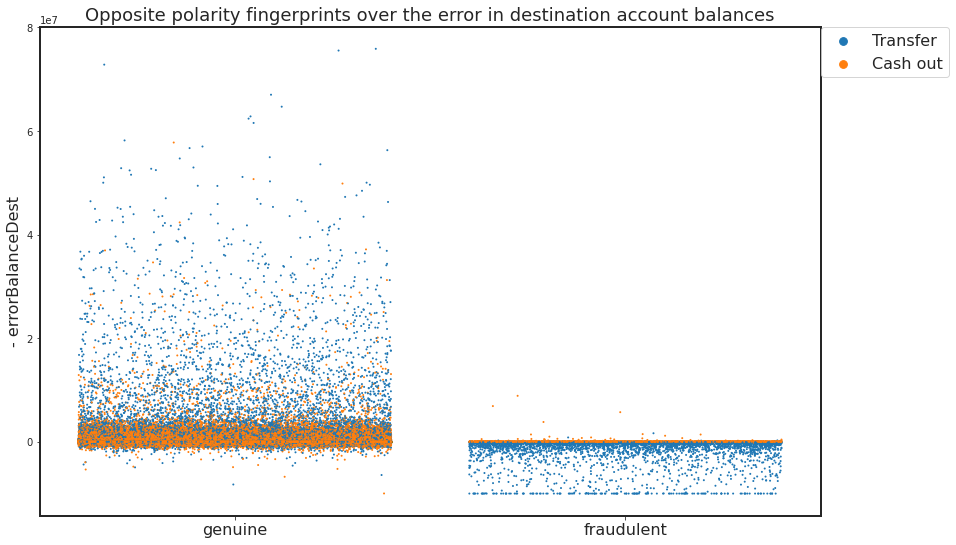

In [25]:
limit = len(X)
ax = plotStrip(Y[:limit], - X.errorBalanceDest[:limit], X.type[:limit], figsize = (14, 9))
ax.set_ylabel("- errorBalanceDest", size = 16)
ax.set_title("Opposite polarity fingerprints over the error in destination account balances", size = 18)

#### 5.4 Separating out genuine from fraudulent transactions

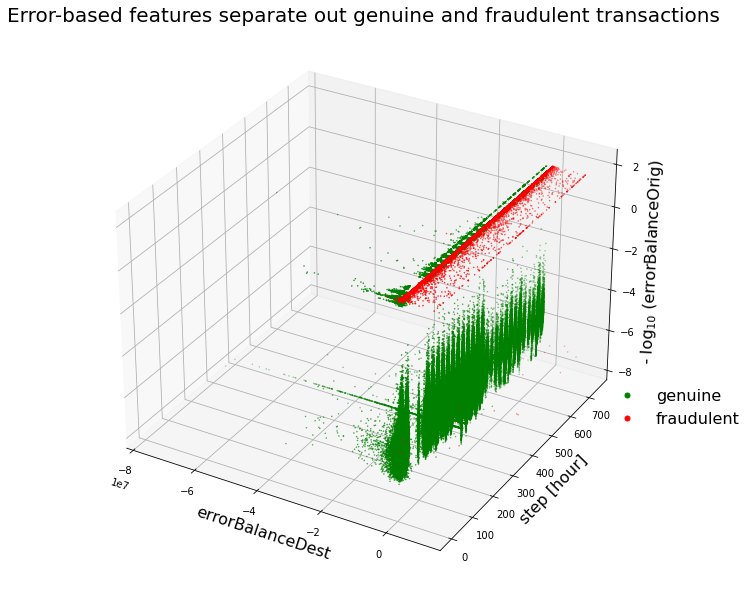

In [26]:
# Long computation in this cell (~2.5 minutes)
x = 'errorBalanceDest'
y = 'step'
z = 'errorBalanceOrig'
zOffset = 0.02
limit = len(X)

sns.reset_orig() # prevent seaborn from over-riding mplot3d defaults

fig = plt.figure(figsize = (10, 12))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X.loc[Y == 0, x][:limit], X.loc[Y == 0, y][:limit], \
  -np.log10(X.loc[Y == 0, z][:limit] + zOffset), c = 'g', marker = '.', \
  s = 1, label = 'genuine')
    
ax.scatter(X.loc[Y == 1, x][:limit], X.loc[Y == 1, y][:limit], \
  -np.log10(X.loc[Y == 1, z][:limit] + zOffset), c = 'r', marker = '.', \
  s = 1, label = 'fraudulent')

ax.set_xlabel(x, size = 16); 
ax.set_ylabel(y + ' [hour]', size = 16); 
ax.set_zlabel('- log$_{10}$ (' + z + ')', size = 16)
ax.set_title('Error-based features separate out genuine and fraudulent \
transactions', size = 20)

plt.axis('tight')
ax.grid(1)

noFraudMarker = mlines.Line2D([], [], linewidth = 0, color='g', marker='.',
                          markersize = 10, label='genuine')
fraudMarker = mlines.Line2D([], [], linewidth = 0, color='r', marker='.',
                          markersize = 10, label='fraudulent')

plt.legend(handles = [noFraudMarker, fraudMarker], \
           bbox_to_anchor = (1.20, 0.38 ), frameon = False, prop={'size': 16});

#### 5.5 Fingerprints of genuine and fraudulent transactions

[Text(1, -1.0, '−1.0'),
 Text(1, -0.5, '−0.5'),
 Text(1, 0.0, '0.0'),
 Text(1, 0.5, '0.5'),
 Text(1, 1.0, '1.0')]

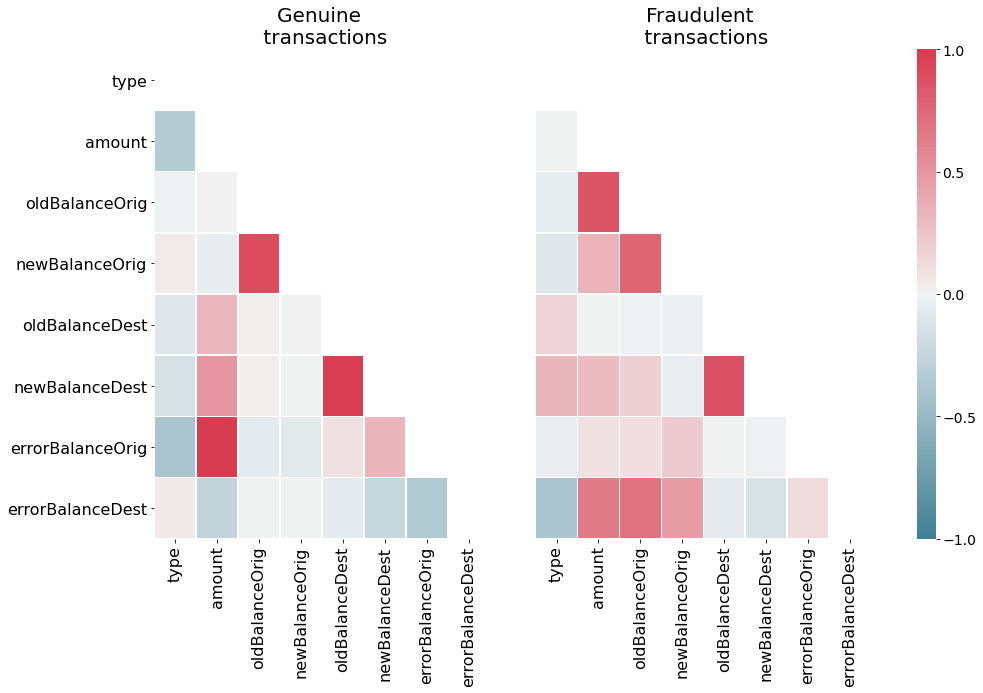

In [27]:
Xfraud = X.loc[Y == 1]
XnonFraud = X.loc[Y == 0]
                  
correlationNonFraud = XnonFraud.loc[:, X.columns != 'step'].corr()
mask = np.zeros_like(correlationNonFraud)
indices = np.triu_indices_from(correlationNonFraud)
mask[indices] = True

grid_kws = {"width_ratios": (.9, .9, .05), "wspace": 0.2}
f, (ax1, ax2, cbar_ax) = plt.subplots(1, 3, gridspec_kw=grid_kws, \
                                     figsize = (14, 9))

cmap = sns.diverging_palette(220, 8, as_cmap=True)
ax1 =sns.heatmap(correlationNonFraud, ax = ax1, vmin = -1, vmax = 1, \
    cmap = cmap, square = False, linewidths = 0.5, mask = mask, cbar = False)
ax1.set_xticklabels(ax1.get_xticklabels(), size = 16); 
ax1.set_yticklabels(ax1.get_yticklabels(), size = 16); 
ax1.set_title('Genuine \n transactions', size = 20)

correlationFraud = Xfraud.loc[:, X.columns != 'step'].corr()
ax2 = sns.heatmap(correlationFraud, vmin = -1, vmax = 1, cmap = cmap, \
 ax = ax2, square = False, linewidths = 0.5, mask = mask, yticklabels = False, \
    cbar_ax = cbar_ax, cbar_kws={'orientation': 'vertical', \
                                 'ticks': [-1, -0.5, 0, 0.5, 1]})
ax2.set_xticklabels(ax2.get_xticklabels(), size = 16); 
ax2.set_title('Fraudulent \n transactions', size = 20);

cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(), size = 14)

### 6. Machine Learning to Detect Fraud in Skewed Data

In [28]:
print('skew = {}'.format( len(Xfraud) / float(len(X)) ))

skew = 0.002964544224336551


In [29]:
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.2, \
                                                random_state = randomState)

In [30]:
weights = (Y == 0).sum() / (1.0 * (Y == 1).sum())
clf = XGBClassifier(max_depth = 3, scale_pos_weight = weights, \
                n_jobs = 4)
probabilities = clf.fit(trainX, trainY).predict_proba(testX)
print('AUPRC = {}'.format(average_precision_score(testY, \
                                              probabilities[:, 1])))

/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:44:31] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
AUPRC = 0.9983642588456605


#### 6.1 ML 모델에서 중요한 특징이 뭔가요?

Text(0.5, 1.0, 'Ordering of features by importance to the model learnt')

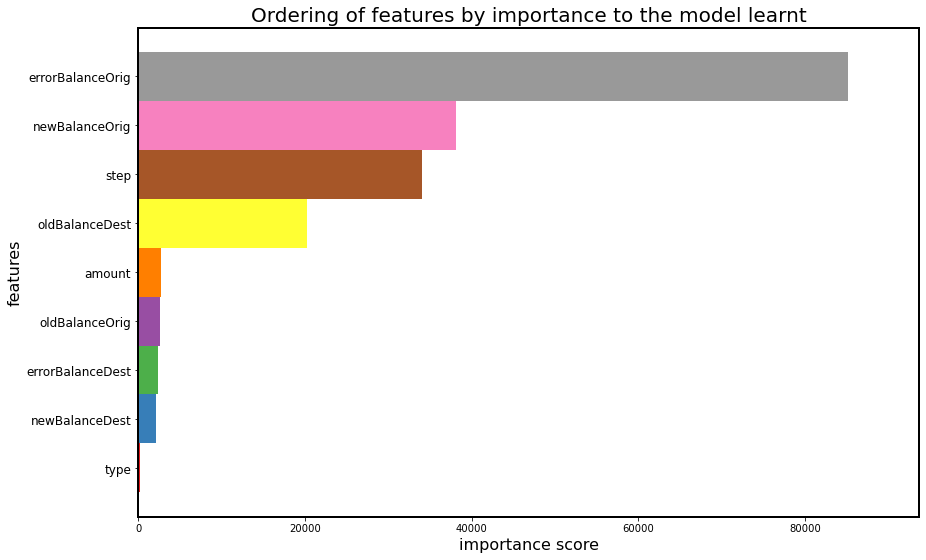

In [31]:
fig = plt.figure(figsize = (14, 9))
ax = fig.add_subplot(111)

colours = plt.cm.Set1(np.linspace(0, 1, 9))

ax = plot_importance(clf, height = 1, color = colours, grid = False, show_values = False, importance_type = "cover", ax = ax)
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(2)
    
ax.set_xlabel("importance score", size = 16)
ax.set_ylabel("features", size = 16)
ax.set_yticklabels(ax.get_yticklabels(), size = 12)
ax.set_title("Ordering of features by importance to the model learnt", size = 20)

#### 6.2 Bias-variance tradeoff

In [ ]:
trainSizes, trainScores, crossValScores = learning_curve(\
XGBClassifier(max_depth = 3, scale_pos_weight = weights, n_jobs = 4), trainX,\
                                         trainY, scoring = 'average_precision')

/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:47:02] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:47:06] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:47:20] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:47:49] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607

In [ ]:
trainScoresMean = np.mean(trainScores, axis=1)
trainScoresStd = np.std(trainScores, axis=1)
crossValScoresMean = np.mean(crossValScores, axis=1)
crossValScoresStd = np.std(crossValScores, axis=1)

colours = plt.cm.tab10(np.linspace(0, 1, 9))

fig = plt.figure(figsize = (14, 9))
plt.fill_between(trainSizes, trainScoresMean - trainScoresStd,
    trainScoresMean + trainScoresStd, alpha=0.1, color=colours[0])
plt.fill_between(trainSizes, crossValScoresMean - crossValScoresStd,
    crossValScoresMean + crossValScoresStd, alpha=0.1, color=colours[1])
plt.plot(trainSizes, trainScores.mean(axis = 1), 'o-', label = 'train', \
         color = colours[0])
plt.plot(trainSizes, crossValScores.mean(axis = 1), 'o-', label = 'cross-val', \
         color = colours[1])

ax = plt.gca()
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles, ['train', 'cross-val'], bbox_to_anchor=(0.8, 0.15), \
               loc=2, borderaxespad=0, fontsize = 16);
plt.xlabel('training set size', size = 16); 
plt.ylabel('AUPRC', size = 16)
plt.title('Learning curves indicate slightly underfit model', size = 20);